## Clasificador Bayesiano

Vamos a comparar contra un clasificador bayesiano para poder ver si lo mejoramos o no.



25.0
900


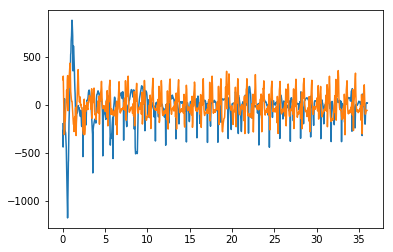

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
#load data
import numpy as np

X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

t = np.arange(len(X_train[0]))/250
plt.plot(t,X_train[0,:])

#Es probable que tengamos un problema mal condicionado: vamos a realizar un submuestreo de la señal a 50 muestras por segundo
from scipy import signal


freq = 250/10#Hz
print(freq)
secs = len(X_train[200])/250
samps = int(secs*freq)
c = 0
X_new = np.zeros((X_train.shape[0],samps))
X_new_test = np.zeros((X_test.shape[0],samps))
for x,x_test in zip(X_train,X_test):
    X_new[c,:] = signal.decimate(x,10)
    X_new_test[c,:] = signal.decimate(x_test,10)
    
    c += 1
    
t = np.arange(len(X_new[200]))/freq
plt.plot(t,X_new[200,:])
print(len(X_new[0]))

X_train = X_new.copy()
X_test = X_new_test.copy()

## Vamos a probar dos modelos:
** 1.- sin utilizar normalización y centrado de los datos **

** 2.- Normalizando y centrando los datos **


### 1 Modelo sin normalización

In [2]:
#1 Sin normalizar

from sklearn.naive_bayes import GaussianNB
from time import time

from sklearn import metrics
#creamos el modelo
clf = GaussianNB()


#entrenamos el modelo
t0 = time()
clf.fit(X_train,y_train)
train_time = time() - t0
print("El tiempo de entrenamiento ha sido: %.2f"%(train_time))





El tiempo de entrenamiento ha sido: 0.24


In [3]:
#Predecimos con el modelo
t0 = time()
y_hat = clf.predict(X_test)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

#obtenemos el conjunto de metricas 

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat,target_names=target_names))


print("confusion matrix:")
print(metrics.confusion_matrix(y_test, y_hat))


#parece que simplemente elige una de las soluciones,debe ser por el problema del balanceado
from collections import Counter

#vamos a ver el número de elementos diferentes en y_test y en y_hat


print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_test")
print(sorted(Counter(y_test).items()))

print("y_hat")
print(sorted(Counter(y_hat).items()))


test time:  0.084s
accuracy:   0.250
classification report:
             precision    recall  f1-score   support

     Normal       0.64      0.33      0.43       736
         AF       0.06      0.05      0.06       100
      Other       0.33      0.10      0.15       335
      Noise       0.03      0.80      0.06        25

avg / total       0.49      0.25      0.31      1196

confusion matrix:
[[241  51  56 388]
 [ 35   5  11  49]
 [101  22  33 179]
 [  2   2   1  20]]
"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_test
[(0, 736), (1, 100), (2, 335), (3, 25)]
y_hat
[(0, 379), (1, 80), (2, 101), (3, 636)]


In [4]:
#Vamos a probar balanceando con under sampling y over sampling
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X_train, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train, y_train)

print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_resampled")
print(sorted(Counter(y_resampled).items()))

print("y_oversampled")
print(sorted(Counter(y_oversampled).items()))


print("y_train")
print(sorted(Counter(y_train).items()))

"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_resampled
[(0, 100), (1, 100), (2, 100), (3, 100)]
y_oversampled
[(0, 2942), (1, 2942), (2, 2942), (3, 2942)]
y_train
[(0, 2942), (1, 399), (2, 1340), (3, 100)]


## Results under sampling

accuracy:   0.133
classification report:
             precision    recall  f1-score   support

     Normal       0.61      0.04      0.08       736
         AF       0.07      0.04      0.05       100
      Other       0.27      0.31      0.29       335
      Noise       0.03      0.80      0.05        25

avg / total       0.46      0.13      0.14      1196

Confusion matrix, without normalization
[[ 31  39 234 432]
 [  3   4  39  54]
 [ 16  16 104 199]
 [  1   1   3  20]]
Normalized confusion matrix
[[0.04 0.05 0.32 0.59]
 [0.03 0.04 0.39 0.54]
 [0.05 0.05 0.31 0.59]
 [0.04 0.04 0.12 0.8 ]]


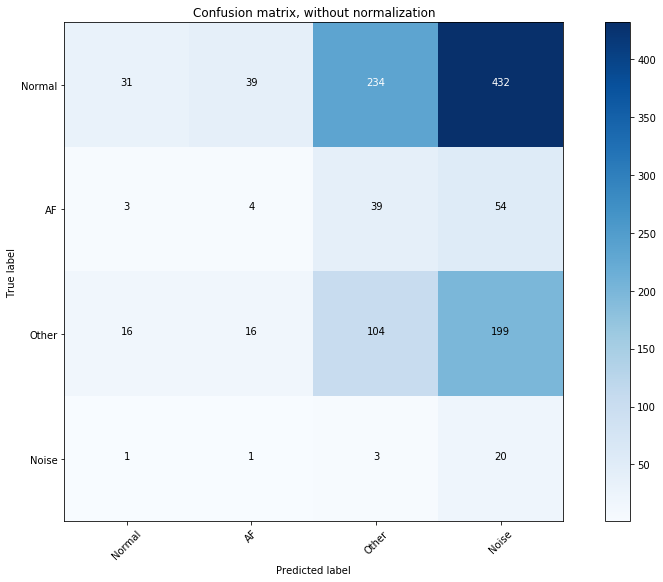

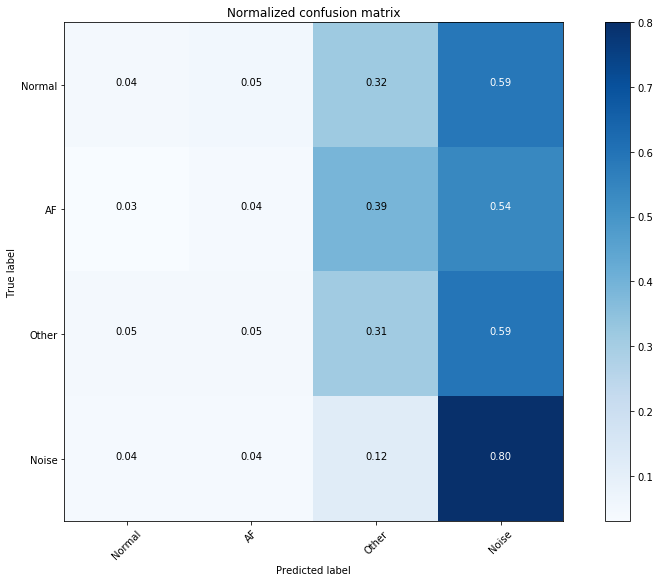

In [5]:
%matplotlib inline
#Resultados under sampling

clf_under = GaussianNB()

clf_under.fit(X_resampled,y_resampled)

y_hat_under = clf_under.predict(X_test)


target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat_under)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat_under,target_names=target_names))

from tfg_tools import *

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_hat_under)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (12,8))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')
plt.figure(figsize = (12,8))
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')



## Results Over sampling

accuracy:   0.252
classification report:
             precision    recall  f1-score   support

     Normal       0.64      0.33      0.43       736
         AF       0.06      0.05      0.06       100
      Other       0.32      0.10      0.15       335
      Noise       0.03      0.80      0.06        25

avg / total       0.49      0.25      0.32      1196

Confusion matrix, without normalization
[[242  50  61 383]
 [ 34   5  11  50]
 [102  22  34 177]
 [  2   2   1  20]]
Normalized confusion matrix
[[0.33 0.07 0.08 0.52]
 [0.34 0.05 0.11 0.5 ]
 [0.3  0.07 0.1  0.53]
 [0.08 0.08 0.04 0.8 ]]


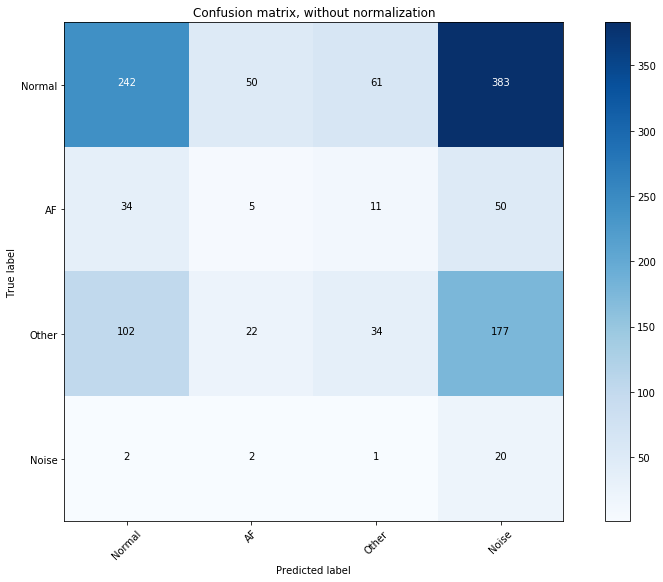

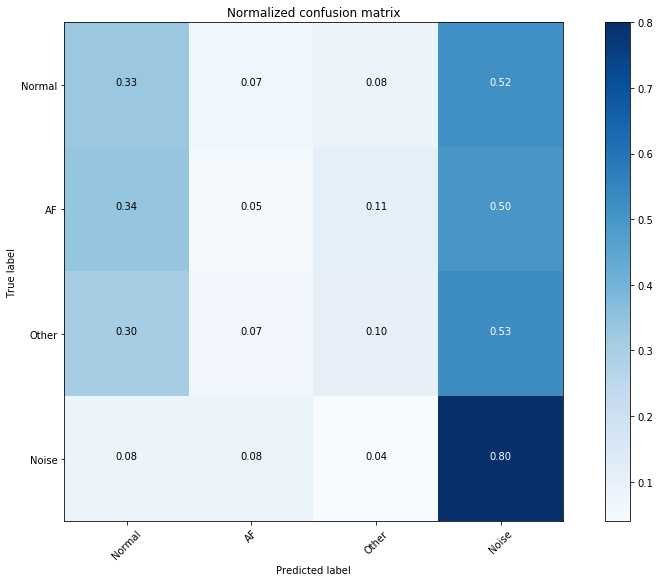

In [6]:
%matplotlib inline
#Resultados under sampling

clf_over = GaussianNB()

clf_over.fit(X_oversampled,y_oversampled)

y_hat_over = clf_over.predict(X_test)


target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat_over)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat_over,target_names=target_names))

from tfg_tools import *

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_hat_over)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (12,8))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')
plt.figure(figsize = (12,8))
# Plot normalized confusion matrix
plot_confusion_matrix(cnf_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

### 2. Modelo Normalizando

In [7]:
from sklearn.preprocessing import StandardScaler

#normalizamos train
my_scaler = StandardScaler()

X_train_n = my_scaler.fit_transform(X_train)
#entrenamos el modelo
t0 = time()
clf.fit(X_train_n,y_train)
train_time = time() - t0
print("El tiempo de entrenamiento ha sido: %.2f"%(train_time))



El tiempo de entrenamiento ha sido: 0.10


test time:  0.040s
accuracy:   0.250
classification report:
             precision    recall  f1-score   support

     Normal       0.64      0.33      0.43       736
         AF       0.06      0.05      0.06       100
      Other       0.33      0.10      0.15       335
      Noise       0.03      0.80      0.06        25

avg / total       0.49      0.25      0.31      1196

confusion matrix:
Confusion matrix, without normalization
[[241  51  56 388]
 [ 35   5  11  49]
 [101  22  33 179]
 [  2   2   1  20]]
"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_test
[(0, 736), (1, 100), (2, 335), (3, 25)]
y_hat
[(0, 379), (1, 80), (2, 101), (3, 636)]


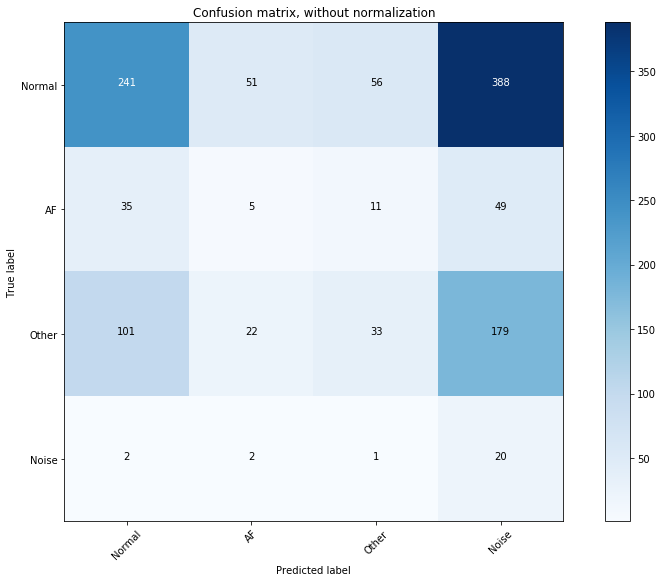

In [8]:
#Predecimos con el modelo

X_test_n = my_scaler.transform(X_test)

t0 = time()
y_hat_n = clf.predict(X_test_n)
test_time = time() - t0
print("test time:  %0.3fs" % test_time)

#obtenemos el conjunto de metricas 

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat_n)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat_n,target_names=target_names))


print("confusion matrix:")
cnf_matrix = metrics.confusion_matrix(y_test, y_hat_n)
# Plot non-normalized confusion matrix
plt.figure(figsize = (12,8))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

#parece que simplemente elige una de las soluciones,debe ser por el problema del balanceado
from collections import Counter

#vamos a ver el número de elementos diferentes en y_test y en y_hat


print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_test")
print(sorted(Counter(y_test).items()))

print("y_hat")
print(sorted(Counter(y_hat_n).items()))


In [9]:
#Undersmapling y oversampling con normalizados

from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0, replacement=True)
X_resampled, y_resampled = rus.fit_sample(X_train_n, y_train)

from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_oversampled, y_oversampled = ros.fit_sample(X_train_n, y_train)

print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print('"""""""""""""""""""""""""""""""""""""""""""""""""')
print("y_resampled")
print(sorted(Counter(y_resampled).items()))

print("y_oversampled")
print(sorted(Counter(y_oversampled).items()))


print("y_train")
print(sorted(Counter(y_train).items()))

"""""""""""""""""""""""""""""""""""""""""""""""""
"""""""""""""""""""""""""""""""""""""""""""""""""
y_resampled
[(0, 100), (1, 100), (2, 100), (3, 100)]
y_oversampled
[(0, 2942), (1, 2942), (2, 2942), (3, 2942)]
y_train
[(0, 2942), (1, 399), (2, 1340), (3, 100)]


accuracy:   0.133
classification report:
             precision    recall  f1-score   support

     Normal       0.61      0.04      0.08       736
         AF       0.07      0.04      0.05       100
      Other       0.27      0.31      0.29       335
      Noise       0.03      0.80      0.05        25

avg / total       0.46      0.13      0.14      1196

Confusion matrix, without normalization
[[ 31  39 234 432]
 [  3   4  39  54]
 [ 16  16 104 199]
 [  1   1   3  20]]


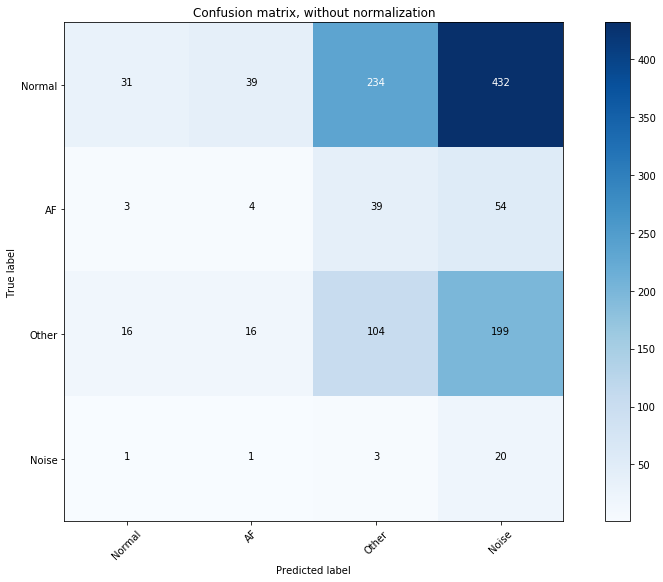

In [10]:
#undersampling con normalización de los datos

clf_under = GaussianNB()

clf_under.fit(X_resampled,y_resampled)


y_hat_under = clf_under.predict(X_test_n)


target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat_under)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat_under,target_names=target_names))

from tfg_tools import *

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_hat_under)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (12,8))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

## Regresión Logística

En último lugar vamos a utilizar regresión logística.



accuracy:   0.261
classification report:
             precision    recall  f1-score   support

     Normal       0.60      0.25      0.35       736
         AF       0.08      0.28      0.13       100
      Other       0.28      0.29      0.29       335
      Noise       0.02      0.20      0.04        25

avg / total       0.46      0.26      0.31      1196

Confusion matrix, without normalization
[[182 209 206 139]
 [ 26  28  33  13]
 [ 84  91  97  63]
 [ 10   5   5   5]]


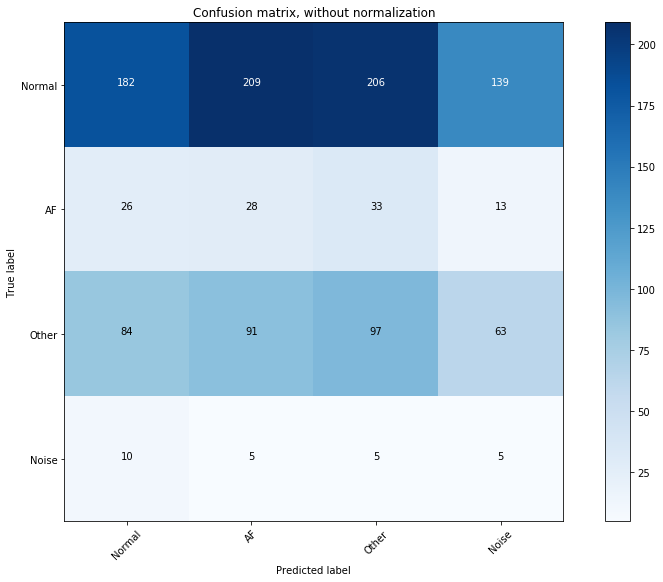

In [11]:
#Regresión logística multinomial

from sklearn.linear_model import LogisticRegression

lr_under = LogisticRegression(multi_class= 'multinomial',solver = 'lbfgs')

#Vamos a utilizar undersampling y oversampling normalizado

lr_under.fit(X_resampled,y_resampled)

y_hat_under = lr_under.predict(X_test_n)

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat_under)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat_under,target_names=target_names))

from tfg_tools import *

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_hat_under)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (12,8))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')

accuracy:   0.348
classification report:
             precision    recall  f1-score   support

     Normal       0.60      0.40      0.48       736
         AF       0.07      0.16      0.10       100
      Other       0.28      0.30      0.29       335
      Noise       0.05      0.24      0.09        25

avg / total       0.45      0.35      0.39      1196

Confusion matrix, without normalization
[[295 155 223  63]
 [ 43  16  30  11]
 [141  59  99  36]
 [ 11   3   5   6]]


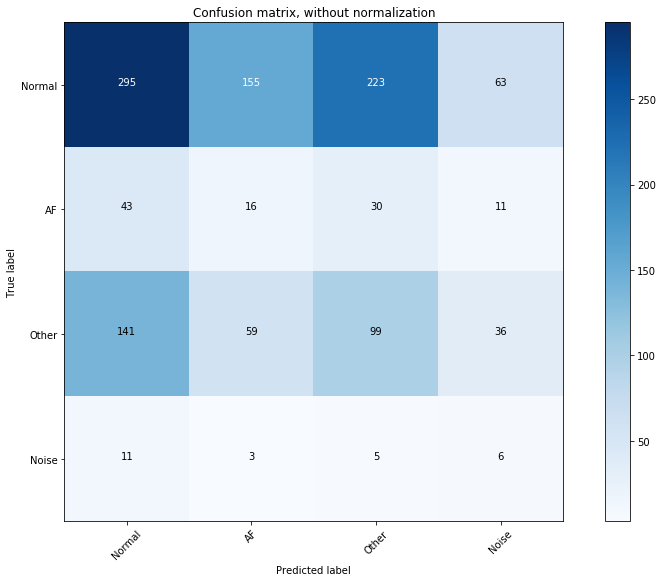

In [12]:

lr_over = LogisticRegression(multi_class= 'multinomial',solver = 'lbfgs')

#Vamos a utilizar undersampling y oversampling normalizado

lr_over.fit(X_oversampled,y_oversampled)

y_hat_over = lr_over.predict(X_test_n)

target_names = ['Normal','AF','Other','Noise']
score = metrics.accuracy_score(y_test, y_hat_over)
print("accuracy:   %0.3f" % score)
#report de metricas
print("classification report:")
print(metrics.classification_report(y_test, y_hat_over,target_names=target_names))

from tfg_tools import *

# Compute confusion matrix
cnf_matrix = metrics.confusion_matrix(y_test, y_hat_over)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize = (12,8))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix, without normalization')